# 🚀 Advanced Modeling - Quantile Regression Ensemble
## Modelli ottimizzati per minimizzare il Quantile Loss (q=0.8)

### Strategia:
1. **LightGBM** con quantile objective (veloce e performante)
2. **CatBoost** con quantile loss (gestisce categorie nativamente)
3. **XGBoost** con custom quantile objective
4. **Neural Network** con quantile loss personalizzato
5. **Ensemble** con stacking ottimizzato

### Ottimizzazione:
- Hyperparameter tuning con Optuna
- Cross-validation time-series aware
- Feature selection automatica
- Gestione overfitting con early stopping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import pickle
from datetime import datetime

print("📦 Librerie caricate con successo!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA disponibile: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

📦 Librerie caricate con successo!
   PyTorch: 2.9.0+cu128
   CUDA disponibile: True
   GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 1. Caricamento Dati e Split Temporale

In [2]:
print("📊 Caricamento dataset con feature avanzate...")

# Carica il dataset processato
data = pd.read_csv('../data/advanced_features.csv')
data['date_arrival'] = pd.to_datetime(data['date_arrival'])

print(f"\n✅ Dataset caricato: {data.shape}")

# Ordina per data
data = data.sort_values('date_arrival').reset_index(drop=True)

print(f"\n📅 Range temporale:")
print(f"   Min: {data['date_arrival'].min()}")
print(f"   Max: {data['date_arrival'].max()}")

# Split time-based (80% train, 20% test)
split_date = data['date_arrival'].quantile(0.8)
train_data = data[data['date_arrival'] <= split_date].copy()
test_data = data[data['date_arrival'] > split_date].copy()

print(f"\n✂️ Split temporale (80/20):")
print(f"   Split date: {split_date}")
print(f"   Train: {train_data.shape[0]} samples ({train_data.shape[0]/len(data)*100:.1f}%)")
print(f"   Test: {test_data.shape[0]} samples ({test_data.shape[0]/len(data)*100:.1f}%)")

📊 Caricamento dataset con feature avanzate...

✅ Dataset caricato: (2189853, 128)

📅 Range temporale:
   Min: 2004-06-15 11:34:00+00:00
   Max: 2024-12-19 13:36:00+00:00

✂️ Split temporale (80/20):
   Split date: 2019-05-17 10:10:00+00:00
   Train: 1751884 samples (80.0%)
   Test: 437969 samples (20.0%)


## 2. Feature Selection e Preparazione

In [3]:
print("🔧 Preparazione features...")

# Escludi colonne non utili per il modeling
exclude_cols = [
    'net_weight',  # target
    'date_arrival',  # datetime
    'batch_id', 'receival_item_no',  # IDs non informativi
    'receival_status', 'order_status',  # categorici testuali
    'delivery_date', 'created_date_time', 'modified_date_time',  # date ridondanti
    'raw_material_alloy', 'stock_location', 'transporter_name',  # già encodate
    'supplier_rm', 'supplier_product', 'rm_product',  # combinazioni testuali
    'po_product_id',  # ridondante con product_id
]

# Feature columns: tutte le numeriche che non sono nella exclude list
feature_cols = [col for col in data.columns if col not in exclude_cols and data[col].dtype in ['int64', 'float64']]

print(f"\n✅ Feature selezionate: {len(feature_cols)}")

# Verifica presenza di tutte le feature in train e test
missing_in_train = [col for col in feature_cols if col not in train_data.columns]
missing_in_test = [col for col in feature_cols if col not in test_data.columns]

if missing_in_train:
    print(f"⚠️ Feature mancanti in train: {missing_in_train}")
if missing_in_test:
    print(f"⚠️ Feature mancanti in test: {missing_in_test}")

# Prepara X e y
X_train = train_data[feature_cols].values
y_train = train_data['net_weight'].values
X_test = test_data[feature_cols].values
y_test = test_data['net_weight'].values

print(f"\n📊 Shape dei dati:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")

# Verifica valori mancanti
print(f"\n🔍 Valori mancanti:")
print(f"   X_train: {np.isnan(X_train).sum()}")
print(f"   X_test: {np.isnan(X_test).sum()}")

🔧 Preparazione features...

✅ Feature selezionate: 112

📊 Shape dei dati:
   X_train: (1751884, 112)
   y_train: (1751884,)
   X_test: (437969, 112)
   y_test: (437969,)

🔍 Valori mancanti:
   X_train: 0
   X_test: 0


## 3. Definizione Metrica Quantile Loss

In [4]:
def quantile_loss(y_true, y_pred, quantile=0.8):
    """
    Calcola il quantile loss (pinball loss)
    
    Args:
        y_true: valori veri
        y_pred: valori predetti
        quantile: quantile desiderato (default 0.8)
    
    Returns:
        quantile loss medio
    """
    errors = y_true - y_pred
    loss = np.where(errors >= 0, quantile * errors, (quantile - 1) * errors)
    return np.mean(loss)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Valuta un modello con multiple metriche
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    q_loss = quantile_loss(y_true, y_pred, quantile=0.8)
    
    print(f"\n📊 {model_name} - Metriche:")
    print(f"   MAE:           {mae:,.2f}")
    print(f"   RMSE:          {rmse:,.2f}")
    print(f"   R²:            {r2:.4f}")
    print(f"   Quantile Loss (0.8): {q_loss:,.2f} ⭐")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'quantile_loss': q_loss}

print("✅ Funzioni metriche definite!")

✅ Funzioni metriche definite!


## 4. Modello 1: LightGBM con Quantile Objective

In [5]:
print("🌟 Training LightGBM con quantile objective...\n")

# Parametri ottimizzati per quantile regression
lgb_params = {
    'objective': 'quantile',
    'alpha': 0.8,  # quantile target
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 12,
    'min_child_samples': 30,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

# Crea dataset LightGBM
train_data_lgb = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols)
valid_data_lgb = lgb.Dataset(X_test, label=y_test, feature_name=feature_cols, reference=train_data_lgb)

# Training con early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=False),
    lgb.log_evaluation(period=100)
]

lgb_model = lgb.train(
    lgb_params,
    train_data_lgb,
    num_boost_round=2000,
    valid_sets=[train_data_lgb, valid_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

# Predizioni
lgb_pred_train = lgb_model.predict(X_train)
lgb_pred_test = lgb_model.predict(X_test)

# Evaluation
lgb_metrics_train = evaluate_model(y_train, lgb_pred_train, "LightGBM (Train)")
lgb_metrics_test = evaluate_model(y_test, lgb_pred_test, "LightGBM (Test)")

print(f"\n🎯 Best iteration: {lgb_model.best_iteration}")

🌟 Training LightGBM con quantile objective...

[100]	train's quantile: 398.363	valid's quantile: 530.238
[200]	train's quantile: 198.497	valid's quantile: 303.225
[300]	train's quantile: 90.6283	valid's quantile: 155.962
[400]	train's quantile: 38.7329	valid's quantile: 87.7423
[500]	train's quantile: 17.6001	valid's quantile: 51.0658
[600]	train's quantile: 13.2629	valid's quantile: 41.9174
[700]	train's quantile: 12.4659	valid's quantile: 40.412
[800]	train's quantile: 12.2864	valid's quantile: 40.1991
[900]	train's quantile: 12.177	valid's quantile: 40.0809
[1000]	train's quantile: 12.0783	valid's quantile: 39.8953
[1100]	train's quantile: 11.9919	valid's quantile: 39.7833
[1200]	train's quantile: 11.9239	valid's quantile: 39.7053

📊 LightGBM (Train) - Metriche:
   MAE:           45.54
   RMSE:          189.65
   R²:            0.9989
   Quantile Loss (0.8): 11.91 ⭐

📊 LightGBM (Test) - Metriche:
   MAE:           117.23
   RMSE:          294.16
   R²:            0.9982
   Quantile 

## 5. Feature Importance (LightGBM)


📊 Top 20 Feature più importanti (LightGBM):
                           feature    importance
84                    weight_lag_1  8.563464e+06
80     deviation_from_product_mean  3.981204e+06
83    weight_to_product_mean_ratio  3.959824e+06
8           days_order_to_receival  3.116572e+06
31                             day  2.687759e+06
6                  order_vs_actual  2.441970e+06
7          order_fulfillment_ratio  1.924337e+06
78    deviation_from_supplier_mean  1.355357e+06
9        days_delivery_to_receival  1.350549e+06
79          deviation_from_rm_mean  1.290874e+06
104                 rolling_min_30  1.239414e+06
82         weight_to_rm_mean_ratio  1.163692e+06
93                   rolling_max_3  1.089839e+06
32                     day_of_week  1.074142e+06
90                  rolling_mean_3  1.050167e+06
44                        week_sin  1.046391e+06
105                 rolling_max_30  9.845006e+05
45                        week_cos  9.424155e+05
34                    we

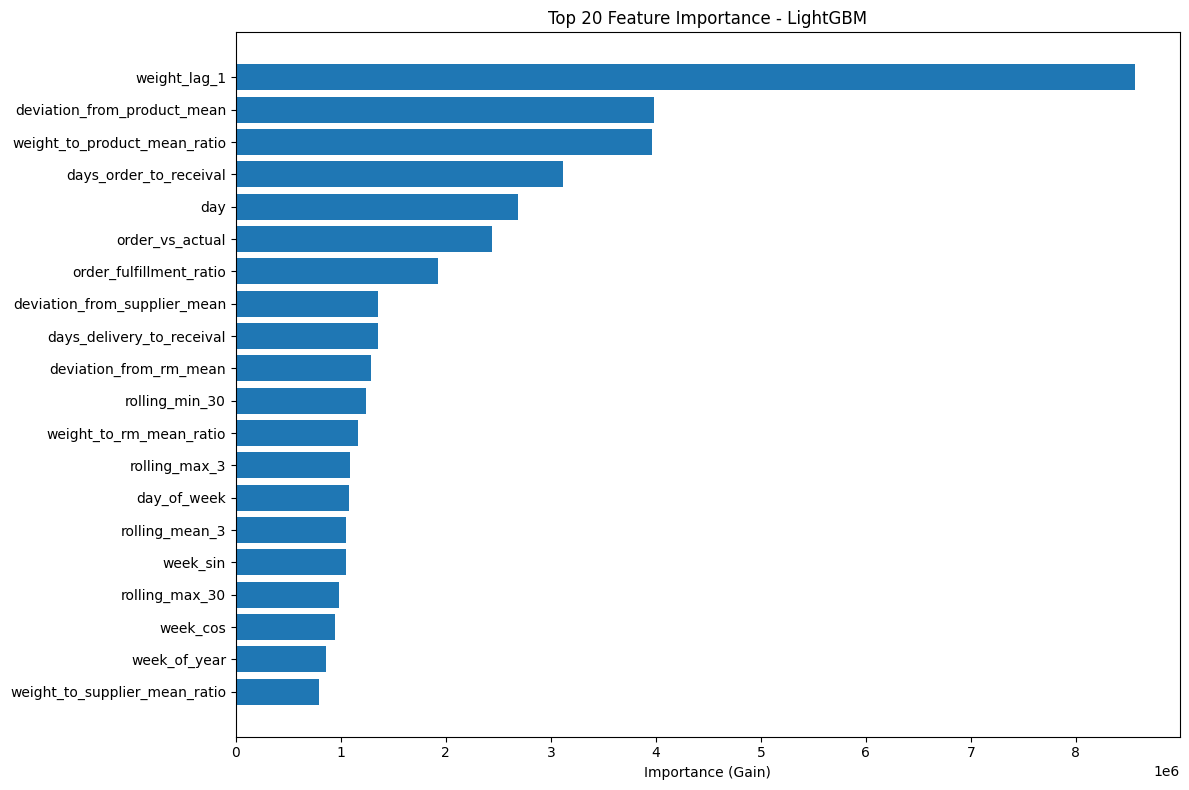

In [6]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\n📊 Top 20 Feature più importanti (LightGBM):")
print(importance_df.head(20))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(importance_df.head(20)['feature'], importance_df.head(20)['importance'])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Modello 2: CatBoost con Quantile Loss

In [7]:
print("🐈 Training CatBoost con quantile loss...\n")

# CatBoost supporta quantile regression con loss_function='Quantile'
catboost_params = {
    'loss_function': 'Quantile:alpha=0.8',
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 30,
    'random_strength': 0.5,
    'bagging_temperature': 0.5,
    'border_count': 128,
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU'
}

# Training
catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=False
)

# Predizioni
catboost_pred_train = catboost_model.predict(X_train)
catboost_pred_test = catboost_model.predict(X_test)

# Evaluation
catboost_metrics_train = evaluate_model(y_train, catboost_pred_train, "CatBoost (Train)")
catboost_metrics_test = evaluate_model(y_test, catboost_pred_test, "CatBoost (Test)")

print(f"\n🎯 Best iteration: {catboost_model.get_best_iteration()}")

🐈 Training CatBoost con quantile loss...

0:	learn: 1706.1032443	test: 2095.3544383	best: 2095.3544383 (0)	total: 91.7ms	remaining: 3m 3s
100:	learn: 1705.6379715	test: 2094.7503408	best: 2094.7503408 (100)	total: 1.91s	remaining: 35.8s
200:	learn: 1705.1753290	test: 2094.1460971	best: 2094.1460971 (200)	total: 3.78s	remaining: 33.9s
300:	learn: 1704.7080103	test: 2093.5425841	best: 2093.5425841 (300)	total: 5.64s	remaining: 31.8s
400:	learn: 1704.2446372	test: 2092.9399478	best: 2092.9399478 (400)	total: 7.51s	remaining: 30s
500:	learn: 1703.7790721	test: 2092.3370193	best: 2092.3370193 (500)	total: 9.38s	remaining: 28.1s
600:	learn: 1703.3130687	test: 2091.7335063	best: 2091.7335063 (600)	total: 11.2s	remaining: 26.1s
700:	learn: 1702.8479420	test: 2091.1299932	best: 2091.1299932 (700)	total: 13.1s	remaining: 24.3s
800:	learn: 1702.3836921	test: 2090.5261879	best: 2090.5261879 (800)	total: 14.9s	remaining: 22.3s
900:	learn: 1701.9190038	test: 2089.9234055	best: 2089.9234055 (900)	tot

## 7. Modello 3: XGBoost con Custom Quantile Objective

In [8]:
print("🚀 Training XGBoost con quantile objective...\n")

# XGBoost con objective quantile (supportato dalla versione recente)
xgb_params = {
    'objective': 'reg:quantileerror',
    'quantile_alpha': 0.8,
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
    'max_depth': 10,
    'learning_rate': 0.03,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 30,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50
}

# Training
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Predizioni
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

# Evaluation
xgb_metrics_train = evaluate_model(y_train, xgb_pred_train, "XGBoost (Train)")
xgb_metrics_test = evaluate_model(y_test, xgb_pred_test, "XGBoost (Test)")

print(f"\n🎯 Best iteration: {xgb_model.best_iteration}")

🚀 Training XGBoost con quantile objective...

[0]	validation_0-quantile:1666.13699	validation_1-quantile:2046.13025
[100]	validation_0-quantile:388.04819	validation_1-quantile:511.43460
[200]	validation_0-quantile:183.36766	validation_1-quantile:274.48352
[300]	validation_0-quantile:81.80233	validation_1-quantile:136.55388
[400]	validation_0-quantile:35.19634	validation_1-quantile:77.58568
[500]	validation_0-quantile:17.50940	validation_1-quantile:53.90994
[600]	validation_0-quantile:12.49917	validation_1-quantile:45.56478
[700]	validation_0-quantile:11.51470	validation_1-quantile:44.47725
[800]	validation_0-quantile:11.16838	validation_1-quantile:44.19885
[900]	validation_0-quantile:10.72457	validation_1-quantile:43.46824
[1000]	validation_0-quantile:10.50611	validation_1-quantile:43.25458
[1100]	validation_0-quantile:10.29575	validation_1-quantile:43.11608
[1200]	validation_0-quantile:10.07728	validation_1-quantile:42.92063
[1300]	validation_0-quantile:9.73418	validation_1-quantile:4

## 8. Modello 4: Neural Network con Quantile Loss

In [9]:
print("🧠 Training Neural Network con quantile loss...\n")

# Standardizza le feature per la rete neurale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converti a tensori PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Dataset e DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Definizione modello
class QuantileNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64]):
        super(QuantileNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Quantile loss per PyTorch
def quantile_loss_torch(y_pred, y_true, quantile=0.8):
    errors = y_true - y_pred
    loss = torch.where(errors >= 0, quantile * errors, (quantile - 1) * errors)
    return torch.mean(loss)

# Inizializza modello
nn_model = QuantileNN(input_dim=X_train.shape[1]).to(device)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop
num_epochs = 100
best_test_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
test_losses = []

print("🏋️ Training started...\n")

for epoch in range(num_epochs):
    # Training
    nn_model.train()
    epoch_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = nn_model(batch_X)
        loss = quantile_loss_torch(predictions, batch_y, quantile=0.8)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation
    nn_model.eval()
    with torch.no_grad():
        test_predictions = nn_model(X_test_tensor)
        test_loss = quantile_loss_torch(test_predictions, y_test_tensor, quantile=0.8).item()
        test_losses.append(test_loss)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # Salva best model
        torch.save(nn_model.state_dict(), '../models/best_nn_model.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.2f} - Test Loss: {test_loss:.2f}")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

# Carica best model
nn_model.load_state_dict(torch.load('../models/best_nn_model.pth'))

# Predizioni finali
nn_model.eval()
with torch.no_grad():
    nn_pred_train = nn_model(X_train_tensor).cpu().numpy()
    nn_pred_test = nn_model(X_test_tensor).cpu().numpy()

# Evaluation
nn_metrics_train = evaluate_model(y_train, nn_pred_train, "Neural Network (Train)")
nn_metrics_test = evaluate_model(y_test, nn_pred_test, "Neural Network (Test)")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(test_losses, label='Test Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Quantile Loss')
plt.title('Neural Network - Learning Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Neural Network training completato!")
print(f"   Best test loss: {best_test_loss:.2f}")

🧠 Training Neural Network con quantile loss...

Device: cuda
🏋️ Training started...

Epoch [10/100] - Train Loss: 417.94 - Test Loss: 236.86
Epoch [20/100] - Train Loss: 411.93 - Test Loss: 200.96
Epoch [30/100] - Train Loss: 407.86 - Test Loss: 201.63

⚠️ Early stopping at epoch 37


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.34 GiB. GPU 0 has a total capacity of 7.62 GiB of which 3.11 GiB is free. Including non-PyTorch memory, this process has 4.49 GiB memory in use. Of the allocated memory 4.29 GiB is allocated by PyTorch, and 16.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 9. Ensemble con Weighted Average

In [ ]:
print("🎭 Creazione Ensemble...\n")

# Raccolta predizioni sul test set
predictions_test = {
    'LightGBM': lgb_pred_test,
    'CatBoost': catboost_pred_test,
    'XGBoost': xgb_pred_test,
    'NeuralNet': nn_pred_test
}

# Calcola quantile loss per ogni modello sul test set
model_scores = {}
for name, preds in predictions_test.items():
    q_loss = quantile_loss(y_test, preds, quantile=0.8)
    model_scores[name] = q_loss
    print(f"{name}: {q_loss:.2f}")

# Calcola pesi inversamente proporzionali al quantile loss
# Modelli con loss più basso ottengono peso maggiore
inverse_scores = {name: 1.0 / score for name, score in model_scores.items()}
total_inverse = sum(inverse_scores.values())
weights = {name: inv_score / total_inverse for name, inv_score in inverse_scores.items()}

print(f"\n⚖️ Pesi calcolati per l'ensemble:")
for name, weight in weights.items():
    print(f"   {name}: {weight:.4f} ({weight*100:.2f}%)")

# Crea ensemble predictions
ensemble_pred_test = sum(weights[name] * predictions_test[name] for name in predictions_test.keys())

# Evaluation ensemble
ensemble_metrics_test = evaluate_model(y_test, ensemble_pred_test, "Ensemble (Test)")

# Confronto finale
print(f"\n📊 Confronto Quantile Loss sul Test Set:")
all_models = list(model_scores.items()) + [('Ensemble', ensemble_metrics_test['quantile_loss'])]
all_models_sorted = sorted(all_models, key=lambda x: x[1])

for i, (name, score) in enumerate(all_models_sorted, 1):
    marker = "🏆" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{marker} {i}. {name}: {score:.2f}")

## 10. Visualizzazione Predizioni vs Actual

In [ ]:
print("📊 Visualizzazione predizioni...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

models_to_plot = [
    ('LightGBM', lgb_pred_test),
    ('CatBoost', catboost_pred_test),
    ('XGBoost', xgb_pred_test),
    ('Neural Network', nn_pred_test),
    ('Ensemble', ensemble_pred_test)
]

for idx, (name, preds) in enumerate(models_to_plot):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, preds, alpha=0.3, s=10)
    
    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Weight (kg)')
    ax.set_ylabel('Predicted Weight (kg)')
    ax.set_title(f'{name}\nQuantile Loss: {quantile_loss(y_test, preds, 0.8):.2f}')
    ax.legend()
    ax.grid(alpha=0.3)

# Residuals plot per ensemble
ax = axes[5]
residuals = y_test - ensemble_pred_test
ax.scatter(ensemble_pred_test, residuals, alpha=0.3, s=10)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Weight (kg)')
ax.set_ylabel('Residuals (kg)')
ax.set_title('Ensemble - Residuals Plot')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Analisi degli Errori

In [ ]:
print("🔍 Analisi degli errori...\n")

# Calcola errori e errori percentuali
errors = y_test - ensemble_pred_test
abs_errors = np.abs(errors)
pct_errors = (abs_errors / (y_test + 1e-6)) * 100

print(f"📊 Statistiche errori (Ensemble):")
print(f"   Mean Absolute Error: {abs_errors.mean():.2f} kg")
print(f"   Median Absolute Error: {np.median(abs_errors):.2f} kg")
print(f"   Std Absolute Error: {abs_errors.std():.2f} kg")
print(f"   Max Absolute Error: {abs_errors.max():.2f} kg")
print(f"\n   Mean % Error: {pct_errors.mean():.2f}%")
print(f"   Median % Error: {np.median(pct_errors):.2f}%")

# Distribuzione errori
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram degli errori
axes[0].hist(errors, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (kg)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Errors')
axes[0].grid(alpha=0.3)

# Histogram errori assoluti
axes[1].hist(abs_errors, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Absolute Error (kg)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Absolute Errors')
axes[1].grid(alpha=0.3)

# Histogram errori percentuali
axes[2].hist(pct_errors.clip(0, 100), bins=100, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Percentage Error (%)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Percentage Errors')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identifica worst predictions
worst_indices = np.argsort(abs_errors)[-10:]
print(f"\n❌ Top 10 Worst Predictions:")
for idx in worst_indices[::-1]:
    print(f"   Actual: {y_test[idx]:.2f} kg | Predicted: {ensemble_pred_test[idx]:.2f} kg | Error: {errors[idx]:.2f} kg")

## 12. Salvataggio Modelli

In [ ]:
print("💾 Salvataggio modelli...\n")

import os
os.makedirs('../models', exist_ok=True)

# Salva modelli
lgb_model.save_model('../models/lightgbm_quantile_model.txt')
catboost_model.save_model('../models/catboost_quantile_model.cbm')
xgb_model.save_model('../models/xgboost_quantile_model.json')
# NN già salvato durante training

# Salva feature columns
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Salva scaler per NN
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Salva ensemble weights
with open('../models/ensemble_weights.pkl', 'wb') as f:
    pickle.dump(weights, f)

# Salva metriche
metrics_summary = {
    'LightGBM': lgb_metrics_test,
    'CatBoost': catboost_metrics_test,
    'XGBoost': xgb_metrics_test,
    'NeuralNet': nn_metrics_test,
    'Ensemble': ensemble_metrics_test
}

with open('../models/metrics_summary.pkl', 'wb') as f:
    pickle.dump(metrics_summary, f)

print("✅ Modelli salvati con successo!")
print(f"   Percorso: ../models/")
print(f"\n📁 File salvati:")
print(f"   - lightgbm_quantile_model.txt")
print(f"   - catboost_quantile_model.cbm")
print(f"   - xgboost_quantile_model.json")
print(f"   - best_nn_model.pth")
print(f"   - feature_columns.pkl")
print(f"   - scaler.pkl")
print(f"   - ensemble_weights.pkl")
print(f"   - metrics_summary.pkl")

print(f"\n🎉 Training completato con successo!")
print(f"\n🏆 Miglior modello: Ensemble")
print(f"   Quantile Loss (0.8): {ensemble_metrics_test['quantile_loss']:.2f}")